In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers, Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, Callback
import tifffile
from sklearn.metrics import classification_report, confusion_matrix
import json

In [2]:
%load_ext tensorboard

In [3]:
curr_dir = os.getcwd()
curr_dir

'C:\\Users\\kenny\\My Files\\NUS\\ISY5002 Pattern Recognition Systems\\04. PRS-PM Practice Module'

In [4]:
model_dir_name = f'{curr_dir}\\Code\\models\\fcn4 CL'
log_dir_name = f'{curr_dir}\\Code\\logs\\fcn4 CL'
output_dir_name = f'{curr_dir}\\Code\\output\\fcn4 CL'

In [5]:
base_dir_name = f'{curr_dir}\\DFC_Public_Dataset\\DFC_Public_Dataset'
all_files = os.listdir(base_dir_name)
season_dirs = [file_name for file_name in all_files if os.path.isdir(os.path.join(base_dir_name, file_name)) and file_name.startswith("ROIs0000")]

print(season_dirs)


['ROIs0000_autumn', 'ROIs0000_spring', 'ROIs0000_summer', 'ROIs0000_winter']


In [6]:
dfc_labels = []
s2_images = []

for season_dir in season_dirs:
    season_dir_path = '{}/{}'.format(base_dir_name, season_dir)
    sub_dirs = os.listdir(season_dir_path)
    sub_dirs = [sub_dir for sub_dir in sub_dirs if sub_dir.startswith("dfc") or sub_dir.startswith("s2")]
    for sub_dir in sub_dirs:
        sub_dir_path = "{}/{}".format(season_dir_path, sub_dir)
        files = os.listdir(sub_dir_path)
        files = ['{}/{}'.format(sub_dir_path, filename) for filename in files]
        if sub_dir.startswith("dfc"):
            dfc_labels.extend(files)
        else:
            s2_images.extend(files)

s2_images.sort()
dfc_labels.sort()



In [7]:
def pre_process_label(label):

    label[(label==4) | (label==6)] = 2 # shrubland, savanna, grassland, croplands
    label[label==5] = 3 # wetlands
    label[label==7] = 4 # urban
    label[label==9] = 5 # urban
    label[label==10] = 6
    return label

In [8]:
X_train, X_test, y_train, y_test = train_test_split(s2_images, dfc_labels, test_size=0.2, random_state=42)

In [9]:
INPUT_SHAPE = (256, 256, 14)
NUM_CLASSES = 7
MAX_VAL = 4096.0

# Augmentation Config
ROTATION_FACTOR = (-0.5, 0.5)
RAND_SEED = 42
SAMPLE_WEIGHT = [0., 1.1033, 1.0629, 1.1714, 1.1273, 1.2035, 1.0667]

# Training Config
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 1e-4
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
def compute_ndvi(image_array):
    # Assuming Red band is the first channel (0th index) and NIR is the second channel (1st index)
    red = image_array[:, :, 3]
    nir = image_array[:, :, 7]

    # Compute NDVI
    ndvi = (nir - red) / (nir + red + 1e-10)  # Small value added to the denominator to prevent division by zero

    return ndvi


In [11]:

def load_and_preprocess_image(img_path):
    #ds = gdal.Open(img_path)
    #img = ds.ReadAsArray()
    #img = np.moveaxis(img, 0, -1)
    if not isinstance(img_path, str):
        img_path = img_path.decode('utf-8')
    with tifffile.TiffFile(img_path) as tif:
        img = tif.asarray()
    band4 = img[:,:,3]
    band8 = img[:, :, 7]
    band11 = img[:, :, 11]
    band11 = tf.expand_dims(band11, axis=-1)  # Add a channel dimension to NDVI
    band4 = tf.expand_dims(band4, axis=-1) 
    band8 = tf.expand_dims(band8, axis=-1) 
    band11 = tf.clip_by_value(tf.cast(band11, tf.float32), 0., 1.)
    band4 = tf.clip_by_value(tf.cast(band4, tf.float32) / MAX_VAL, 0., 1.)
    band8 = tf.clip_by_value(tf.cast(band8, tf.float32) / MAX_VAL, 0., 1.)
    
    ndvi = compute_ndvi(img)
    ndvi = tf.expand_dims(ndvi, axis=-1)
    ndvi = (ndvi + 1.0) / 2.0
    ndvi = tf.clip_by_value(tf.cast(ndvi, tf.float32), 0., 1.)
    img = tf.clip_by_value(tf.cast(img, tf.float32) / MAX_VAL, 0., 1.)
    
    combined_img = tf.concat([img, ndvi], axis=-1)

    return combined_img




def load_and_preprocess_label(label_path):
    #ds = gdal.Open(label_path)
    #label = ds.ReadAsArray()
    if not isinstance(label_path, str):
        label_path = label_path.decode('utf-8')
    with tifffile.TiffFile(label_path) as tif:
        label = tif.asarray()
    label = pre_process_label(label)
    label = label[:,:,np.newaxis]
    return label

In [12]:
# Define a generator function that yields batches of data
def data_generator(img_path_arr,label_path_arr):

    for (img_path,label_path) in zip(img_path_arr,label_path_arr):
        img = load_and_preprocess_image(img_path)
        label = load_and_preprocess_label(label_path)
        sample_weights = np.zeros_like(label, dtype=np.float32)
        for class_idx, weight in enumerate(SAMPLE_WEIGHT):
            sample_weights[label == class_idx] = weight

        yield img, label#, sample_weights


# Create a dataset from the generator function
ori_train_ds = tf.data.Dataset.from_generator(
    data_generator,
    args=(X_train, y_train),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 14), dtype=tf.float32),  # Example: Data tensor specification
        tf.TensorSpec(shape=(256,256,1), dtype=tf.uint8)
    )
)

# Create a dataset from the generator function
ori_eval_ds = tf.data.Dataset.from_generator(
    data_generator,
    args=(X_test, y_test),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 14), dtype=tf.float32),  # Example: Data tensor specification
        tf.TensorSpec(shape=(256,256,1), dtype=tf.uint8) # Example: Label tensor specification
    )
)

In [13]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [14]:
img_aug = Sequential([
        # layers.Resizing(height=self.img_size, width=self.img_size, interpolation='bicubic'),
        layers.experimental.preprocessing.RandomContrast(factor=(0.07, 0.1), seed=RAND_SEED),
        layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomFlip(mode='vertical', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomRotation(ROTATION_FACTOR, fill_mode='reflect', interpolation='bilinear', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomTranslation(height_factor=0.15, width_factor=0.15, fill_mode='reflect', interpolation='bilinear', seed=RAND_SEED)
    ])

label_aug = Sequential([
        # layers.Resizing(height=self.img_size, width=self.img_size, interpolation='nearest'),
        layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomFlip(mode='vertical', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomRotation(ROTATION_FACTOR, fill_mode='reflect', interpolation='nearest', seed=RAND_SEED),
        layers.experimental.preprocessing.RandomTranslation(height_factor=0.15, width_factor=0.15, fill_mode='reflect', interpolation='nearest', seed=RAND_SEED)
    ])


In [15]:
#batched_train_ds = ori_train_ds.batch(BATCH_SIZE)
augmented_train_ds = (
    ori_train_ds.shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    # .map(img_aug, num_parallel_calls=AUTOTUNE)
    .map(lambda img, label: (img_aug(img), label_aug(label)), num_parallel_calls=AUTOTUNE)
    # .map(lambda img, label: (apply_blur(img), label), num_parallel_calls=AUTOTUNE)
    
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    ori_eval_ds
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)



C:\Users\kenny\anaconda3\envs\tfGPU\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [16]:
import numpy as np

def calculate_pixel_frequencies(dataset):
    # Initialize an array to store pixel frequencies for each class
    class_counts = np.zeros(7)  # Assuming classes are labeled from 0 to 6
    
    # Iterate over the dataset to count pixel frequencies
    for _, label in dataset:  # Assuming dataset yields (image, label) pairs
        unique, counts = np.unique(label, return_counts=True)
        for u, c in zip(unique, counts):
            class_counts[int(u)] += c

    return class_counts
def compute_class_weights(pixel_frequencies):
    # Compute class weights using the 'balanced' approach
    total_pixels = np.sum(pixel_frequencies)
    class_weights = total_pixels / (7 * pixel_frequencies)  # 7 classes

    return class_weights
# Calculate pixel frequencies from your dataset

gen_iter = iter(data_generator(s2_images, dfc_labels))
sample_img, sample_label = next(gen_iter)
print(sample_img.shape)


pixel_freqs = calculate_pixel_frequencies(ori_train_ds)

# Compute class weights
weights = compute_class_weights(pixel_freqs)


(256, 256, 14)


C:\Users\kenny\AppData\Local\Temp\ipykernel_11136\349571227.py:17: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_pixels / (7 * pixel_frequencies)  # 7 classes


In [17]:
if np.isinf(weights[0]):
    weights[0] = np.mean(weights[1:])

print(weights)

[1.9196781  0.61651863 0.41368626 3.13537743 1.42635145 5.35599681
 0.57013805]


In [18]:
import os

class PlotPredictions(Callback):
    def __init__(self, test_ds, num_samples=3, plot_every=5, save_path="."):
        super().__init__()
        self.test_ds = test_ds
        self.num_samples = num_samples
        self.plot_every = plot_every
        self.save_path = save_path
    
    

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.plot_every == 0:
            # Randomly select samples
            samples = np.random.choice(len(X_test), self.num_samples, replace=False)

            fig, ax = plt.subplots(self.num_samples, 2, figsize=(10, 5 * self.num_samples))

            for i, sample_index in enumerate(samples):
                img, actual_label = next(iter(self.test_ds.skip(sample_index).take(1)))
                img = tf.reshape(img, [1, 256, 256, 14])

                predicted_label = np.argmax(model.predict(img), axis=-1)

                predicted_label = predicted_label.reshape((predicted_label.shape[1], predicted_label.shape[2]))
                # Plot actual label

                actual_label = tf.reshape(actual_label, [actual_label.shape[0], actual_label.shape[1]])
                actual_label = actual_label.numpy()

                ax[i, 0].imshow(actual_label, cmap='tab10', vmin=0, vmax=5)
                ax[i, 0].set_title(f"Actual Label {i+1}")

                ax[i, 1].imshow(predicted_label, cmap='tab10', vmin=0, vmax=5)
                ax[i, 1].set_title(f"Predicted Label {i+1}")

            plt.tight_layout()

            # Save the combined plot
            file_name = f"{self.save_path}/FCN4CL_test_{epoch}.png"
            save_location = os.path.join(self.save_path, file_name)
            plt.savefig(save_location)
            plt.close()

# Usage



In [19]:
class ClassificationReportCallback(Callback):
    def __init__(self, dataset, steps, filepath="classification_report.json", matrix_path="confusion_matrix.png"):
        super(ClassificationReportCallback, self).__init__()
        self.dataset = dataset
        self.steps = steps
        self.filepath = filepath
        self.matrix_path = matrix_path
        self.reports = []

    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(self.matrix_path)
        plt.close()

    def on_epoch_end(self, epoch, logs=None):
        if(epoch + 1) % 5 == 0:
            y_true = []
            y_pred_list = []

            # Iterate over the dataset to get predictions and true labels
            for step, (x_batch, y_batch) in enumerate(self.dataset.take(self.steps)):
                y_true.extend(y_batch.numpy().reshape(-1))
                y_pred_probs = model.predict(x_batch)
                y_pred = np.argmax(y_pred_probs, axis=-1).reshape(-1)
                y_pred_list.extend(y_pred)

            y_true = np.array(y_true)
            y_pred_list = np.array(y_pred_list)

            # Compute classification report
            report = classification_report(y_true, y_pred_list, output_dict=True)

            # Compute per-class accuracy
            accuracy_per_class = {}
            for i in range(len(np.unique(y_true))):
                correct = np.sum((y_true == i) & (y_pred_list == i))
                total = np.sum(y_true == i)
                accuracy = correct / total
                accuracy_per_class[f"class_{i}"] = accuracy

            # Compute confusion matrix
            cm = confusion_matrix(y_true, y_pred_list)
            self.plot_confusion_matrix(cm, classes=np.unique(y_true), title='Confusion Matrix')

            # Debug output for file paths
            print("JSON File Path:", self.filepath)
            print("PNG File Path:", self.matrix_path)
            
            # Append to reports
            self.reports.append({
                "epoch": epoch,
                "classification_report": report,
                "accuracy_per_class": accuracy_per_class
            })

            # Save to JSON file
            with open(self.filepath, 'w') as f:
                json.dump(self.reports, f)

In [20]:
from tensorflow.keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    """
    weights = tf.constant(weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        #y_true = tf.cast(y_true, tf.float32)
        
        y_true = tf.one_hot(tf.cast(tf.squeeze(y_true, axis=-1), tf.int32), depth=7)
        class_loglosses = K.mean(K.categorical_crossentropy(y_true, y_pred, from_logits=False), axis=[0, 1, 2])
        return K.sum(class_loglosses * K.constant(weights))


    return loss


In [21]:
plot_predictions_cb = PlotPredictions(ori_eval_ds, save_path=output_dir_name)

In [22]:
tensorboard_callback = TensorBoard(log_dir=log_dir_name, histogram_freq=1, update_freq=5)


In [23]:
model_file_name = f"{model_dir_name}/model_FCN4_CL.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_file_name,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [24]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [25]:
loss_function = weighted_categorical_crossentropy(weights)


In [34]:
from fcn4 import *

fcn4model = fcn4(n_classes = NUM_CLASSES, shape  = INPUT_SHAPE)
model = fcn4model.get_model()

# visualize(model, 'model.jpg')

model.compile(tf.keras.optimizers.Adam(LEARNING_RATE), loss=loss_function, metrics=['accuracy'])

In [27]:
def plot_history(history, epoch_count, filename):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss at Epoch {epoch_count}')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy at Epoch {epoch_count}')
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

In [35]:
model.load_weights(f"{model_dir_name}/model_FCN4_CL.h5")

In [28]:
# epochs_list = [10, 20, 30, 40, 50]
epochs_list = [10, 20]

# Assuming you have already defined your model, training_data, and validation_data
for epochs in epochs_list:
    # If not the first stage, load weights from the previous stage
    if epochs != epochs_list[0]:
        model.load_weights(f"{model_dir_name}/model_FCN4_CL.h5")

    # Train the model
    classification_rep_filename = f'{output_dir_name}/classication_report_{epochs}.json'
    confusion_matrix_filename = f'{output_dir_name}/confusion_matrix_{epochs}.png'
    
    classification_rep_callback = ClassificationReportCallback(val_ds, len(X_test), classification_rep_filename,
                                                              confusion_matrix_filename)
    history = model.fit(
        augmented_train_ds,
        validation_data=val_ds,
        epochs=epochs,
#         callbacks=[early_stopping_callback, model_checkpoint_callback, plot_predictions_cb, tensorboard_callback,
#                   classification_rep_callback],
        callbacks=[early_stopping_callback, model_checkpoint_callback, plot_predictions_cb, tensorboard_callback],
        initial_epoch=epochs - 10  # Start from the last epoch
    )

    # Plot and save the history
    filename = f"{output_dir_name}/plots_FCN4CL_epoch_{epochs}.png"
    plot_history(history, epochs, filename)

Epoch 1/10
    612/Unknown - 246s 383ms/step - loss: 16.8398 - accuracy: 0.5176
Epoch 1: val_loss improved from inf to 11.74033, saving model to C:\Users\kenny\My Files\NUS\ISY5002 Pattern Recognition Systems\04. PRS-PM Practice Module\Code\models\fcn4 CL\model_FCN4_CL.h5
612/612 [==============================] - 372s 588ms/step - loss: 16.8398 - accuracy: 0.5176 - val_loss: 11.7403 - val_accuracy: 0.6924
Epoch 2/10
612/612 [==============================] - ETA: 0s - loss: 12.8271 - accuracy: 0.6462
Epoch 2: val_loss improved from 11.74033 to 9.88960, saving model to C:\Users\kenny\My Files\NUS\ISY5002 Pattern Recognition Systems\04. PRS-PM Practice Module\Code\models\fcn4 CL\model_FCN4_CL.h5
612/612 [==============================] - 361s 588ms/step - loss: 12.8271 - accuracy: 0.6462 - val_loss: 9.8896 - val_accuracy: 0.7722
Epoch 3/10
612/612 [==============================] - ETA: 0s - loss: 11.8917 - accuracy: 0.6849
Epoch 3: val_loss improved from 9.88960 to 9.88567, saving mode

ResourceExhaustedError: {{function_node __wrapped__OneHot_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[102760448,30] and type double on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:OneHot]

#### Print Classification Report and Confusion Matrix for FCN8_Custom_Loss

In [36]:
# Make predictions
predicts = model.predict(val_ds)
print("Prediction completes.")
# print("Predictions Shape:", predicts.shape)
# unique_predicted_labels = np.unique(np.argmax(predicts, axis=-1))
# print("Unique Predicted Labels:", unique_predicted_labels)

153/153 [==============================] - 21s 137ms/step
Prediction completes.


In [37]:
def Extract_Flat_Labels (predicts, eval_ds):
    
    predicted_labels = np.argmax(predicts, axis=-1)

    # Extract true labels
    true_labels = np.concatenate([label.numpy() for _, label in eval_ds])
    # Assuming true_labels is array of floating-point labels
    true_labels = true_labels.astype(int)

    # Squeeze the extra dimension in true_labels
    true_labels_squeezed = np.squeeze(true_labels, axis=-1)
    
    # Flatten both predictions and true labels
    predicted_labels_flat = predicted_labels.reshape(-1)
    true_labels_flat = true_labels_squeezed.reshape(-1)
    
    return (predicted_labels_flat, true_labels_flat)

In [38]:
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score

def Classification_Report(predicts, eval_ds, class_names, class_labels):
    
    predicted_labels_flat, true_labels_flat = Extract_Flat_Labels (predicts, eval_ds)
    class_names = class_names
    class_labels = class_labels

    # Extract and display metrics
    f1_scores = metrics.f1_score(true_labels_flat, predicted_labels_flat, average=None)
    avg_f1_score = metrics.f1_score(true_labels_flat, predicted_labels_flat, average="weighted")
    accuracy = metrics.accuracy_score(true_labels_flat, predicted_labels_flat)
    recall = metrics.recall_score(true_labels_flat, predicted_labels_flat, average=None, zero_division=1)
    precision = metrics.precision_score(true_labels_flat, predicted_labels_flat, average=None, zero_division=1)
    
    # Check the number of classes in the metrics
    num_classes_in_metrics = len(f1_scores)

    # Make sure class_labels only includes the first num_classes_in_metrics labels
    class_labels = class_labels[:num_classes_in_metrics]

    print("Classification accuracy {:.1f}%".format(100 * accuracy))
    print("Classification F1-score {:.1f}%".format(100 * avg_f1_score))
    print()
    print("             Class                   =  F1    | Recall | Precision")
    print("         --------------------------------------------------------")
    for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
        # Check if the index is within bounds
        if idx < len(f1_scores):
            f1 = f1_scores[idx]
            recall_score = recall[idx]
            precision_score = precision[idx]
        else:
            # Handle the case where the index is out of bounds
            f1 = 0.0
            recall_score = 0.0
            precision_score = 0.0
        
        line_data = (lulctype, f1_scores[idx] * 100, recall[idx] * 100, precision[idx] * 100)
        print("         * {0:25s} = {1:5.1f} | {2:6.1f} | {3:8.1f}".format(*line_data))


In [39]:
class_names = ['0 - Others', '1 - Forest', '2 - Shrub/Grass/Cropland', '3 - Wetlands', 
               '4 - Urban', '5 - Barren', '6 - Waterbodies']
class_labels = [0, 1, 2, 3, 4, 5, 6]

eval_ds = val_ds

Classification_Report(predicts, eval_ds, class_names, class_labels)

Classification accuracy 78.1%
Classification F1-score 76.9%

             Class                   =  F1    | Recall | Precision
         --------------------------------------------------------
         * 0 - Others                =  75.0 |   71.3 |     79.2
         * 1 - Forest                =  75.9 |   82.8 |     70.1
         * 2 - Shrub/Grass/Cropland  =  52.6 |   45.1 |     63.2
         * 3 - Wetlands              =  66.6 |   63.7 |     69.8
         * 4 - Urban                 =   5.2 |    2.7 |     85.1
         * 5 - Barren                =  95.3 |   96.2 |     94.5


In [40]:
# confusion matrix
predicted_labels_flat, true_labels_flat = Extract_Flat_Labels (predicts, eval_ds)

confusion = metrics.confusion_matrix(true_labels_flat,predicted_labels_flat)
print(confusion)

[[12694011  4419620   142389   365945      150   191599]
 [ 2731987 23474533   720261  1061693     5155   350774]
 [  153490  1436875  1670348   154067      244   289110]
 [  313985  2215131    12675  4754639      274   168094]
 [   42861  1458091     3754   382174    56482   156755]
 [   92189   502973    91998    97856     4091 19934255]]


In [41]:
import itertools

def conf_matrix(
    confusion_matrix,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
    ylabel="True label",
    xlabel="Predicted label",
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        normalisation_factor = confusion_matrix.sum(axis=1)[:, np.newaxis] + np.finfo(float).eps
        confusion_matrix = confusion_matrix.astype("float") / normalisation_factor

    plt.imshow(confusion_matrix, interpolation="nearest", cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = ".2f" if normalize else "d"
    threshold = confusion_matrix.max() / 2.0
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(
            j,
            i,
            format(confusion_matrix[i, j], fmt),
            horizontalalignment="center",
            color="white" if confusion_matrix[i, j] > threshold else "black",
            fontsize=12,
        )

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

In [42]:
def Plot_Confusion_Matrix(predicts, eval_ds, class_names, class_labels):

    import itertools
   
    predicted_labels_flat, true_labels_flat = Extract_Flat_Labels (predicts, eval_ds)    
    fig = plt.figure(figsize=(20, 20))

    plt.subplot(1, 2, 1)
    confusion_matrix_gbm = metrics.confusion_matrix(true_labels_flat, predicted_labels_flat)
    conf_matrix(
        confusion_matrix_gbm,
        classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
        normalize=True,
        ylabel="Truth (LAND COVER)",
        xlabel="Predicted (GBM)",
        title="Confusion matrix",
    )

    plt.subplot(1, 2, 2)
    confusion_matrix_gbm = metrics.confusion_matrix(predicted_labels_flat, true_labels_flat)
    conf_matrix(
        confusion_matrix_gbm,
        classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
        normalize=True,
        xlabel="Truth (LAND COVER)",
        ylabel="Predicted (GBM)",
        title="Transposed Confusion matrix",
    )

    plt.tight_layout()

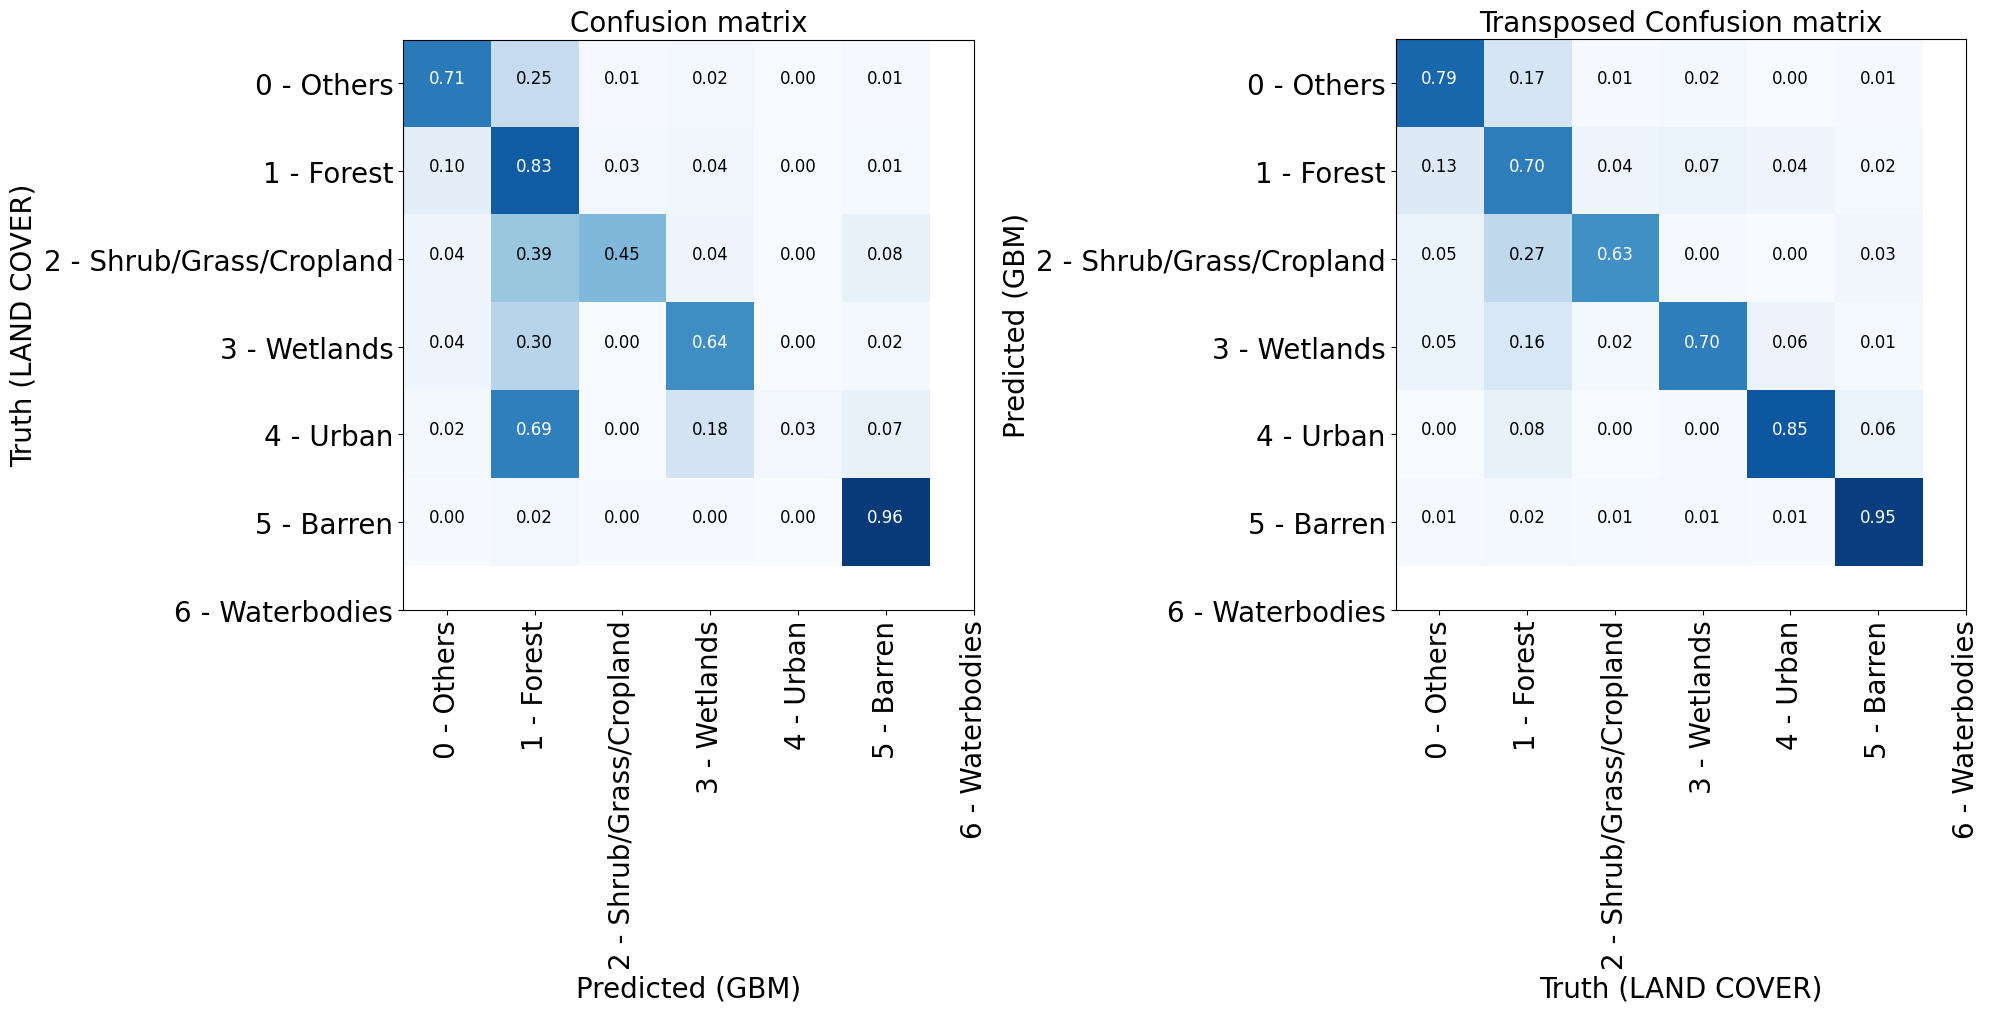

In [43]:
Plot_Confusion_Matrix(predicts, eval_ds, class_names, class_labels)